In [1]:
import pandas as pd
import numpy as np
import random

from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
import plotly.express as px

from statsmodels.tsa.seasonal import seasonal_decompose


In [24]:
df = pd.read_parquet('../data/curated/weighted_monthly_transactions.parquet')
df['merchant_abn'] = df['merchant_abn'].astype(str)
df = pd.pivot_table(
    df.groupby(
        'merchant_abn'
    ).filter(
        lambda x : x['weighted_dollar_value'].sum() > 1000
    ),
    values = 'weighted_dollar_value',
    index = ['order_datetime'],
    columns = 'merchant_abn'
)

In [26]:
def fit_arima(merchant):
    train = merchant[:-6]
    test = merchant[-6:]
    model = auto_arima(train, start_p=1, start_q=1,
        test='adf',
        max_p=12, max_q=12,
        m=1,             
        d=None,          
        seasonal=False,   
        start_P=0, 
        D=None, 
        trace=True,
        error_action='ignore',  
        suppress_warnings=True, 
        stepwise=True
    )
    prediction, confint = model.predict(n_periods=len(test), return_conf_int=True)
    prediction = pd.Series(prediction,index=test.index)
    cf= pd.DataFrame(confint)
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    print(np.mean([np.abs(a - p) for a, p in zip(test, prediction)]))
    ax.plot(merchant)
    ax.plot(prediction)
    ax.fill_between(
        prediction.index,
        cf[0],
        cf[1],color='grey',alpha=.3
    )


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=164.306, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=148.311, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=159.381, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=144.693, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=146.374, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=145.005, Time=0.50 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=136.335, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=134.388, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=134.291, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=133.697, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=135.854, Time=0.28 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.87 se

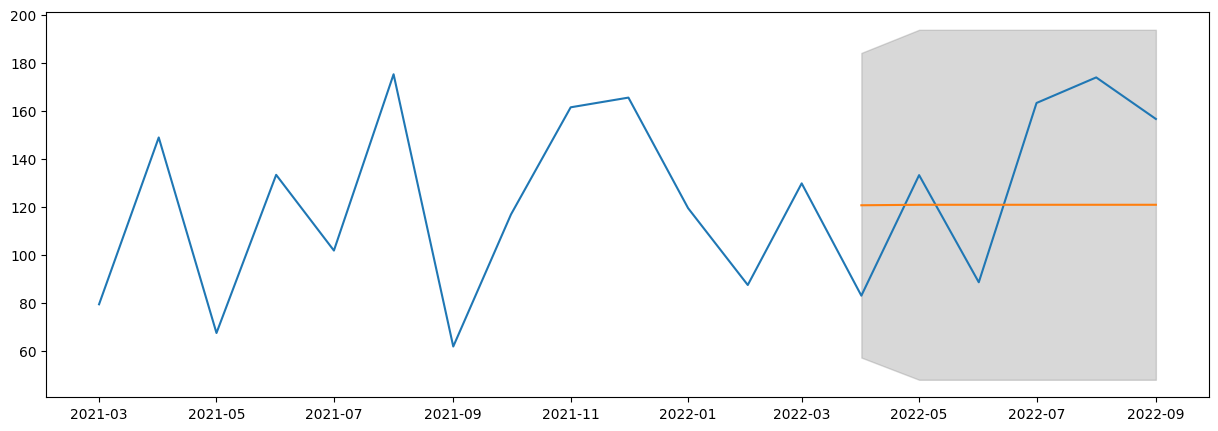

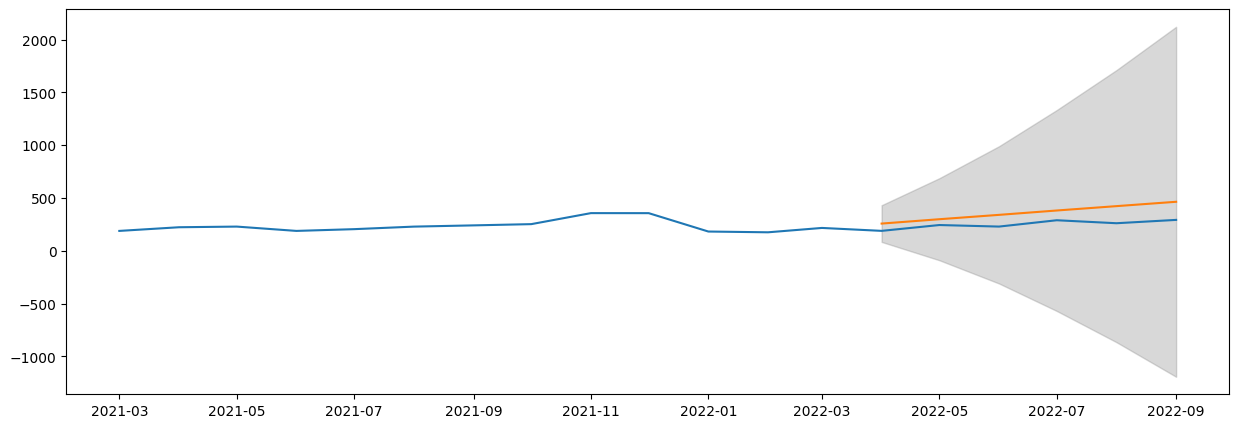

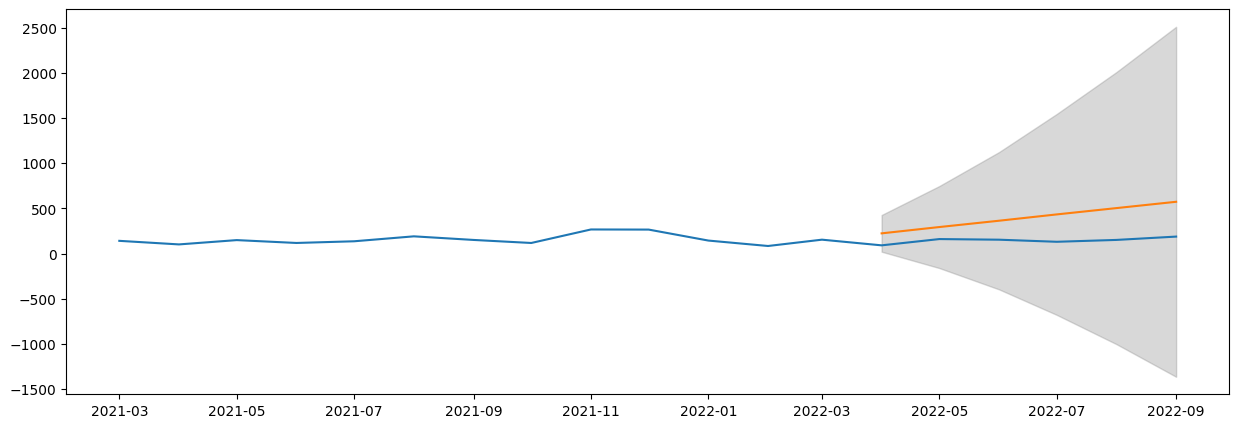

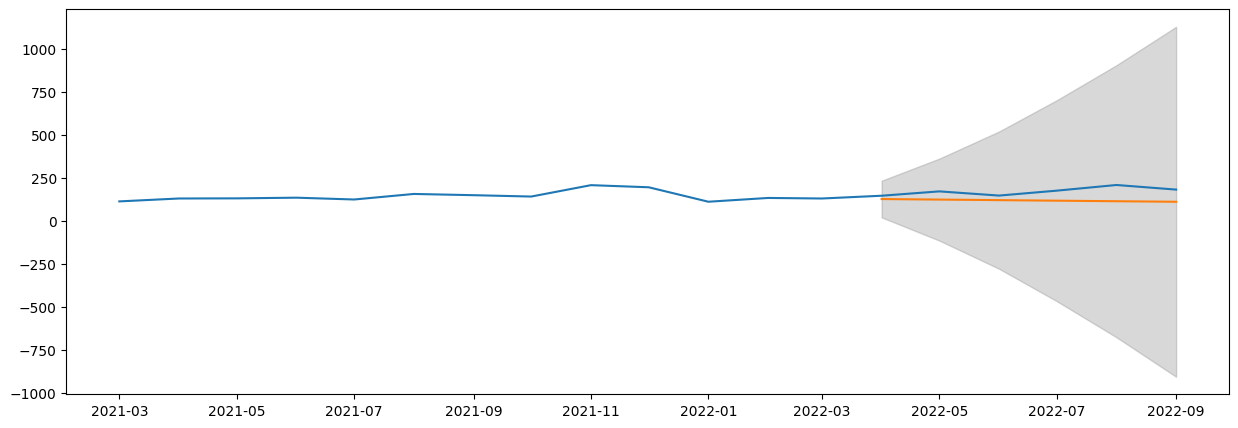

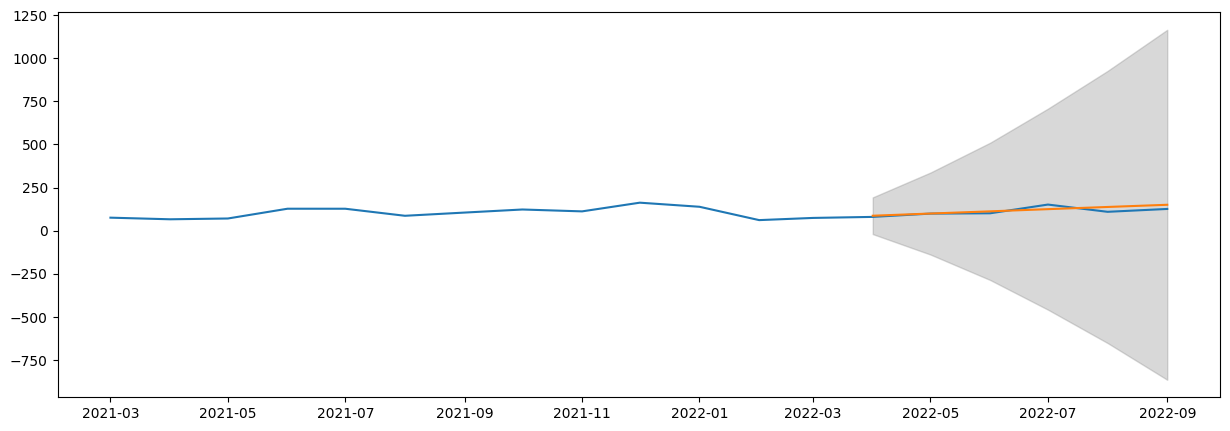

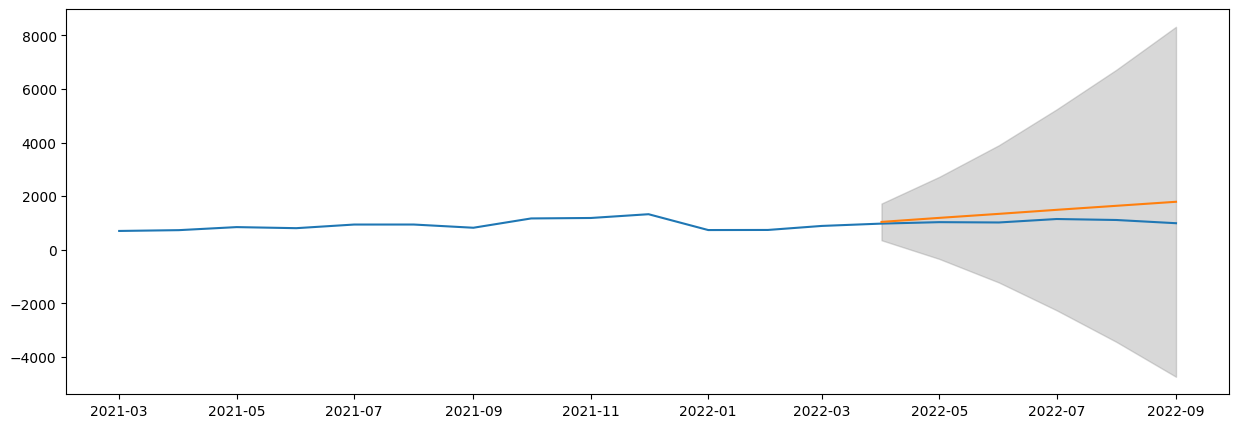

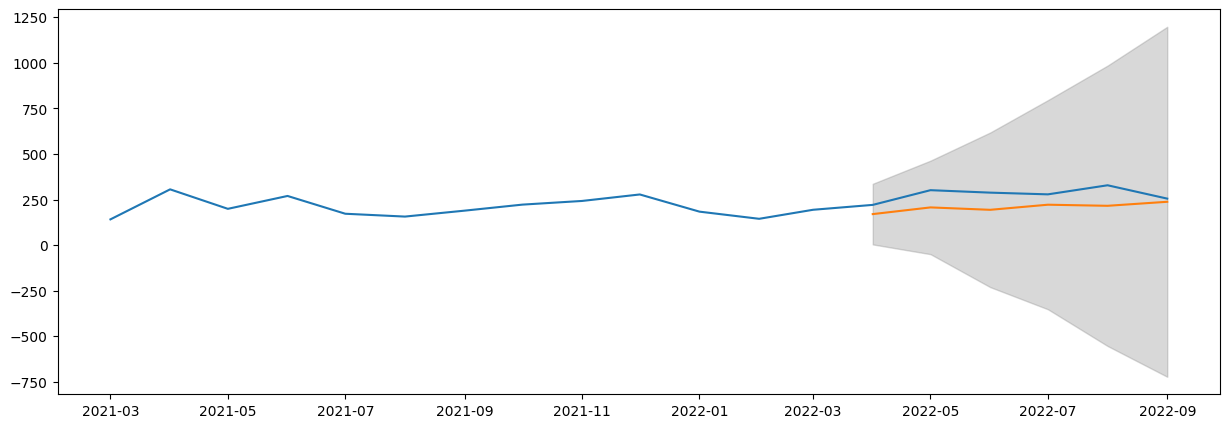

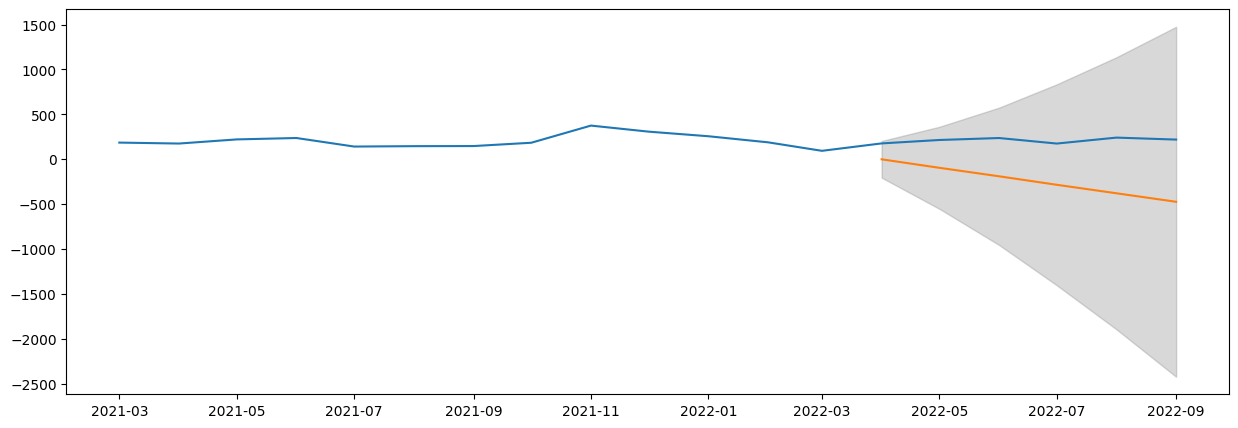

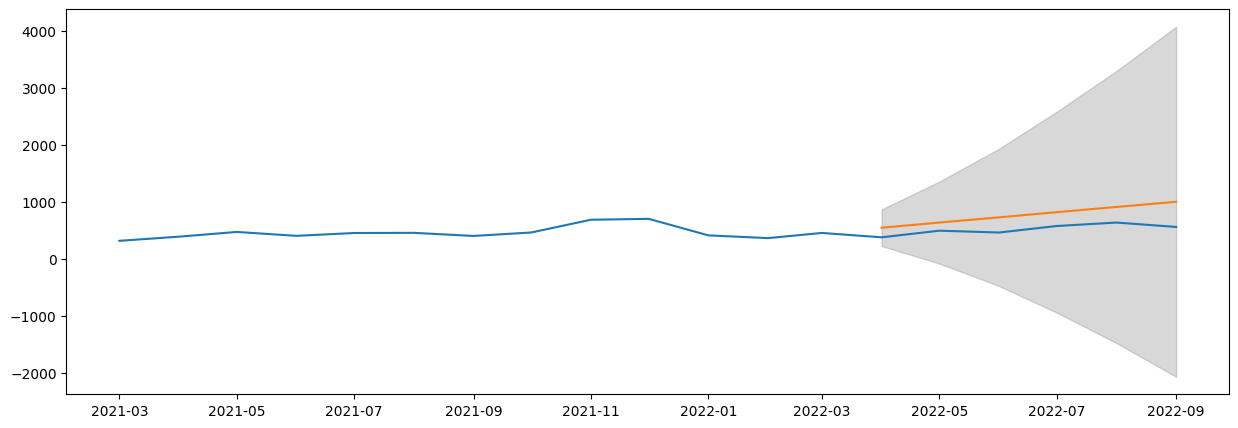

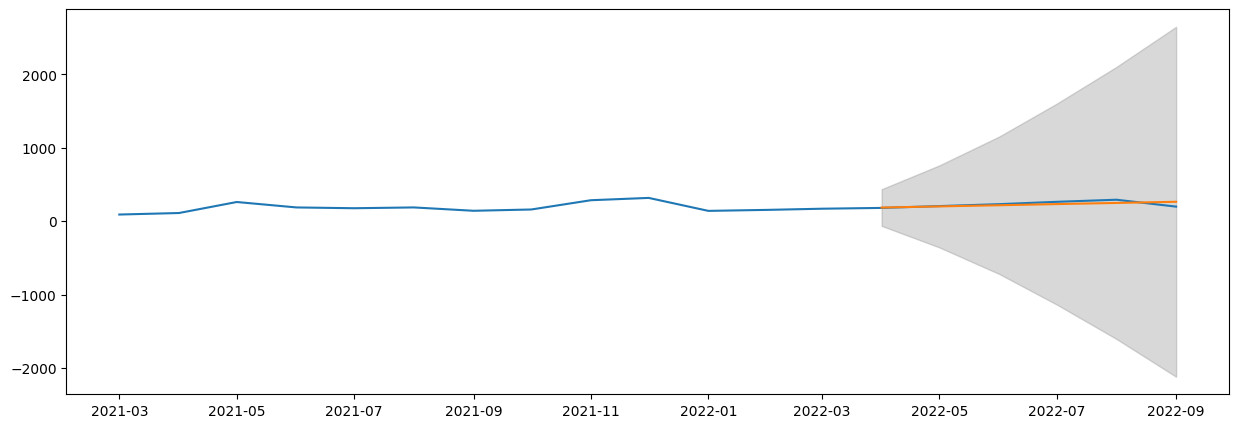

In [27]:
for i in range(10):
    fit_arima(df[df.columns[i]])